In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt   
import seaborn as sns             

In [3]:
def map_to_macrocategory(category):
    if category in ['BEVERAGES', 'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                    'GROCERY I', 'GROCERY II', 'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']:
        return 'Alimentos e Bebidas'
    elif category in ['BABY CARE', 'BEAUTY', 'PERSONAL CARE']:
        return 'Cuidados Pessoais e Saúde'
    elif category in ['CLEANING', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 
                      'HOME CARE', 'LAWN AND GARDEN']:
        return 'Casa e Jardim'
    elif category in ['LADIESWEAR', 'LINGERIE']:
        return 'Moda e Vestuário'
    elif category == 'AUTOMOTIVE':
        return 'Automotivo'
    elif category == 'PET SUPPLIES':
        return 'Animais de Estimação'
    elif category in ['BOOKS', 'MAGAZINES', 'CELEBRATION', 'PLAYERS AND ELECTRONICS', 'HARDWARE']:
        return 'Lazer, Tecnologia e Ferramentas'
    elif category == 'LIQUOR,WINE,BEER':
        return 'Bebidas Alcoólicas'
    elif category == 'SCHOOL AND OFFICE SUPPLIES':
        return 'Escola e Escritório'
    else:
        return 'Outros'

In [4]:
def adding_date(data):
    data['date']= pd.to_datetime(data['date'])
    data.set_index('date', inplace = True)
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'date'}, inplace=True)
    return data


In [40]:
def payday(date):
    if date.day == 15:
        return 1
    elif date == pd.Timestamp(date.year, date.month, 1) + pd.DateOffset(months=1) - pd.DateOffset(days=1):
        return 1
    else:
        return 0

In [5]:
treino = pd.read_csv('Data/train.csv.gz', compression='gzip')
treino= treino.drop(columns=['id'])
treino['date']= pd.to_datetime(treino['date'])
stores = pd.read_csv('Data/stores.csv')
oil = pd.read_csv('Data/oil.csv')
holidays = pd.read_csv('Data/holidays_events.csv')

In [6]:
null_counts = oil.isnull().sum()
print(null_counts)

date           0
dcoilwtico    43
dtype: int64


In [7]:
oil = adding_date(oil)

In [8]:
oil.iloc[0] = oil.iloc[0].fillna(95)
oil =oil.ffill()

In [9]:
dados= pd.merge(treino, oil, on=['date'], how= 'left')

In [10]:
dados.describe

<bound method NDFrame.describe of               date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  dcoilwtico  
0                  0       95.00  
1                  0       95.00  
2       

In [11]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 137.4+ MB


In [12]:
dados["family"].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [13]:
null_counts = dados.isnull().sum()
print(null_counts)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64


In [14]:
dados['holiday'] = 0

In [15]:
holidays['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [16]:
# Adicionando coluna 'holiday' com 0 inicialmente
dados['holiday'] = 0
holidays['transferred'] = holidays['transferred'].astype(bool)
holidays['date']= pd.to_datetime(holidays['date'])
# Merge de 'dados' com 'stores' para trazer 'city' e 'state'
dados = dados.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')

# Selecionando apenas colunas relevantes de 'holidays' para o merge
holidays_relevant = holidays[['date', 'locale', 'locale_name', 'transferred']]

# Merge de 'dados' com 'holidays' alinhando por 'date' e considerando as colunas relevantes
dados = dados.merge(holidays_relevant, on='date', how='left', suffixes=('', '_hol'))
dados['transferred'] = dados['transferred'].fillna(False)
# Condições para definir 'holiday' com base em 'locale'
dados.loc[(dados['locale'] == 'National') & ~dados['transferred'], 'holiday'] = 1
dados.loc[(dados['locale'] == 'Regional') & (dados['locale_name'] == dados['state']) & ~dados['transferred'], 'holiday'] = 1
dados.loc[(dados['locale'] == 'Local') & (dados['locale_name'] == dados['city']) & ~dados['transferred'], 'holiday'] = 1

# Limpar colunas desnecessárias se necessário
dados.drop(columns=['city', 'state', 'locale', 'locale_name', 'transferred'], errors='ignore', inplace=True)

In [17]:
dados.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dcoilwtico            float64
holiday                 int64
dtype: object

In [18]:
len(stores["type"].unique())

5

In [19]:
print(dados.describe())

                                date     store_nbr         sales  \
count                        3054348  3.054348e+06  3.054348e+06   
mean   2015-04-26 12:11:45.717619200  2.750000e+01  3.590209e+02   
min              2013-01-01 00:00:00  1.000000e+00  0.000000e+00   
25%              2014-03-01 00:00:00  1.400000e+01  0.000000e+00   
50%              2015-04-28 12:00:00  2.750000e+01  1.100000e+01   
75%              2016-06-22 00:00:00  4.100000e+01  1.960110e+02   
max              2017-08-15 00:00:00  5.400000e+01  1.247170e+05   
std                              NaN  1.558579e+01  1.107286e+03   

        onpromotion    dcoilwtico       holiday  
count  3.054348e+06  3.054348e+06  3.054348e+06  
mean   2.617480e+00  6.786101e+01  8.599118e-02  
min    0.000000e+00  2.619000e+01  0.000000e+00  
25%    0.000000e+00  4.632000e+01  0.000000e+00  
50%    0.000000e+00  5.341000e+01  0.000000e+00  
75%    0.000000e+00  9.572000e+01  0.000000e+00  
max    7.410000e+02  1.106200e+02  1.

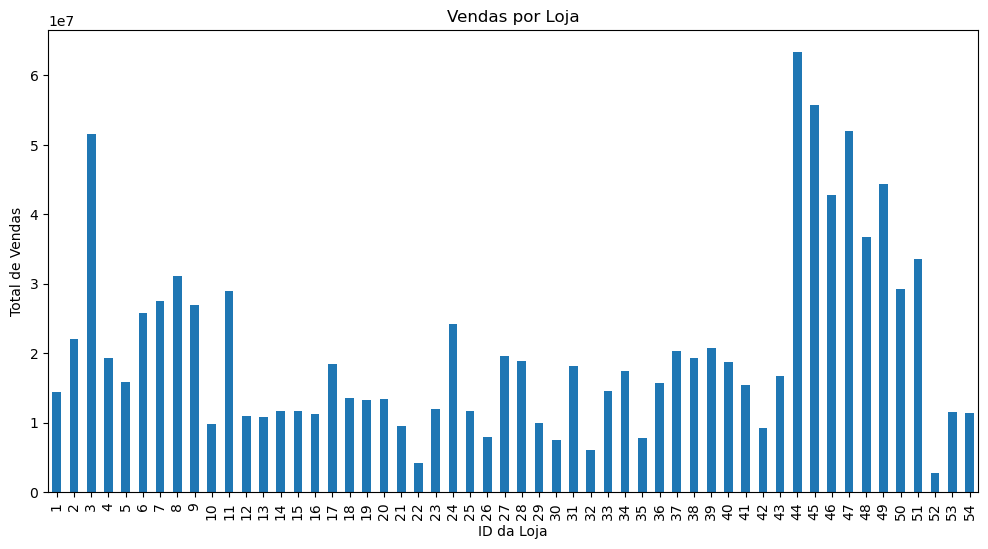

In [20]:
vendas_por_loja = dados.groupby('store_nbr')['sales'].sum()
plt.figure(figsize=(12, 6))
vendas_por_loja.plot(kind='bar')
plt.title('Vendas por Loja')
plt.xlabel('ID da Loja')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=90)
plt.show()

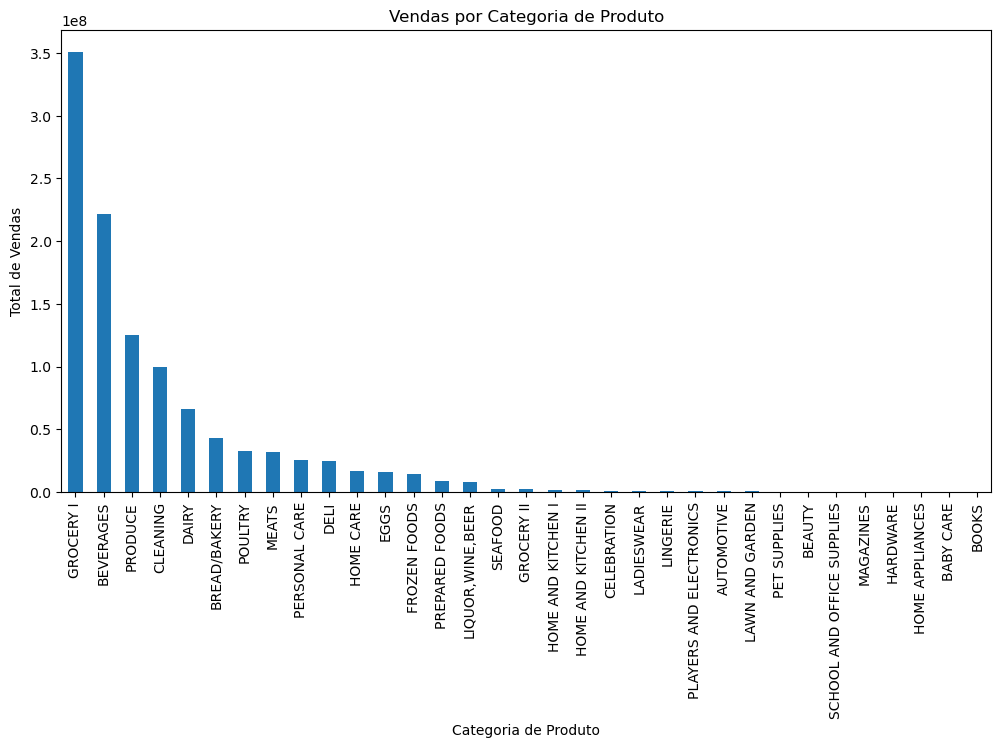

In [21]:
vendas_por_categoria = dados.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
vendas_por_categoria.plot(kind='bar')
plt.title('Vendas por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=90)
plt.show()

In [22]:
dados.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'dcoilwtico',
       'holiday'],
      dtype='object')

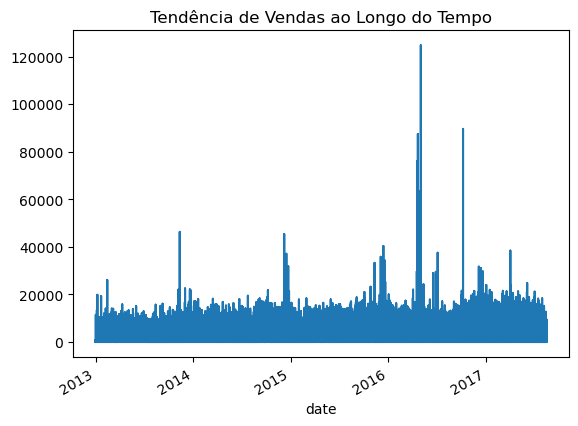

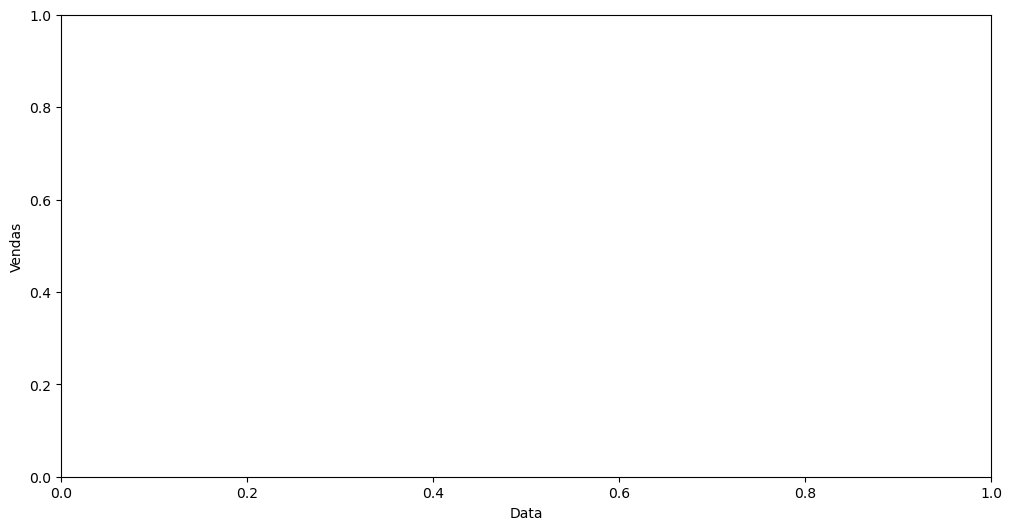

In [23]:
dados.set_index('date')['sales'].plot()
plt.title('Tendência de Vendas ao Longo do Tempo')
plt.figure(figsize=(12, 6))
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()

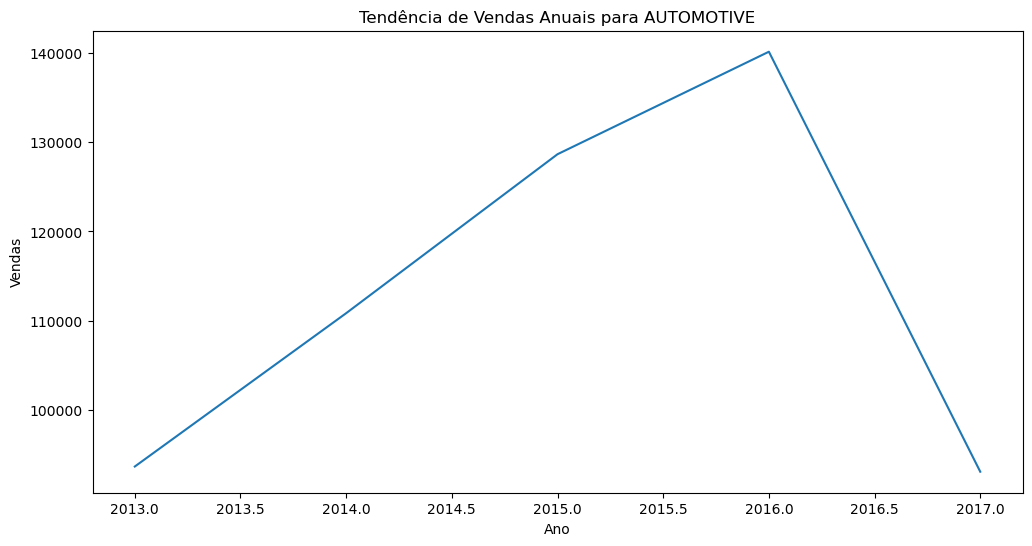

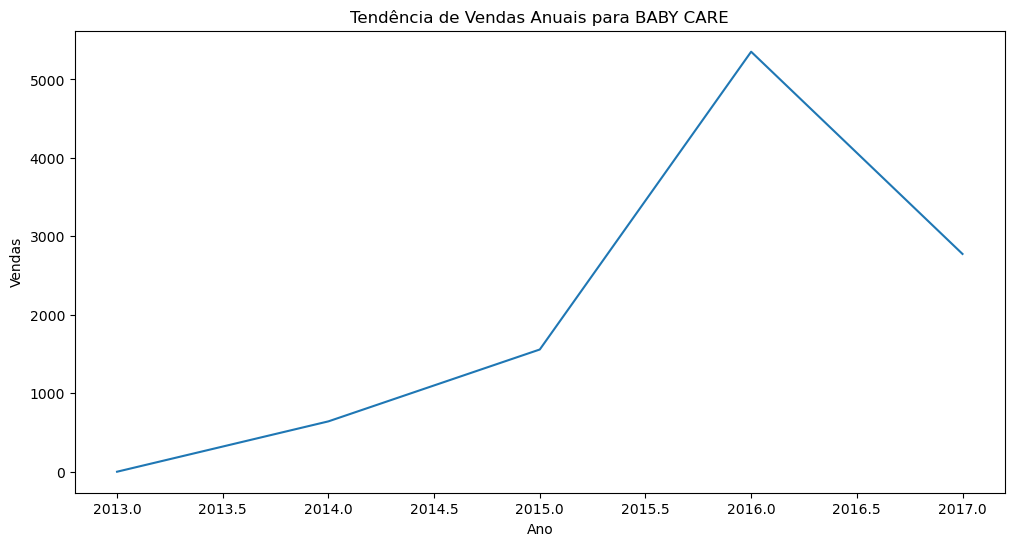

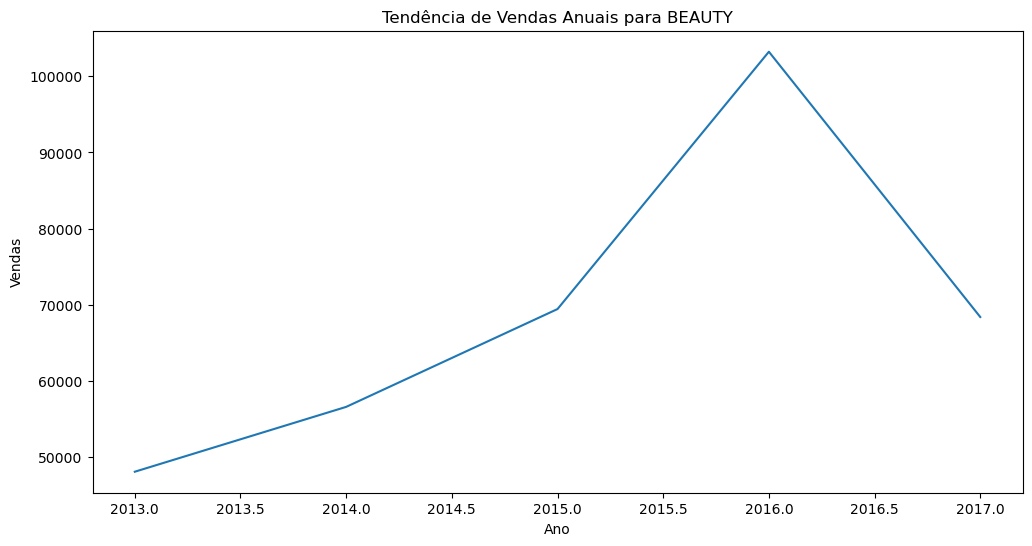

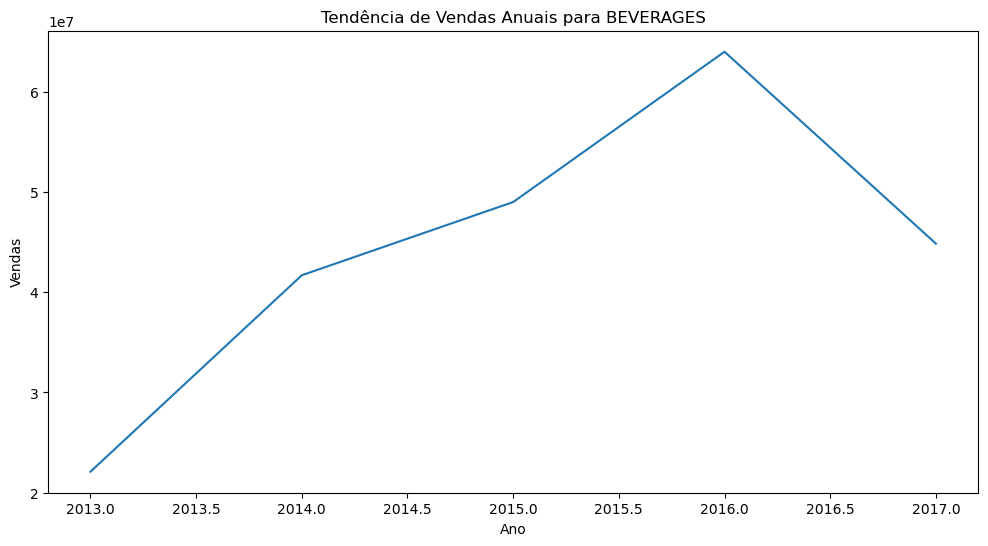

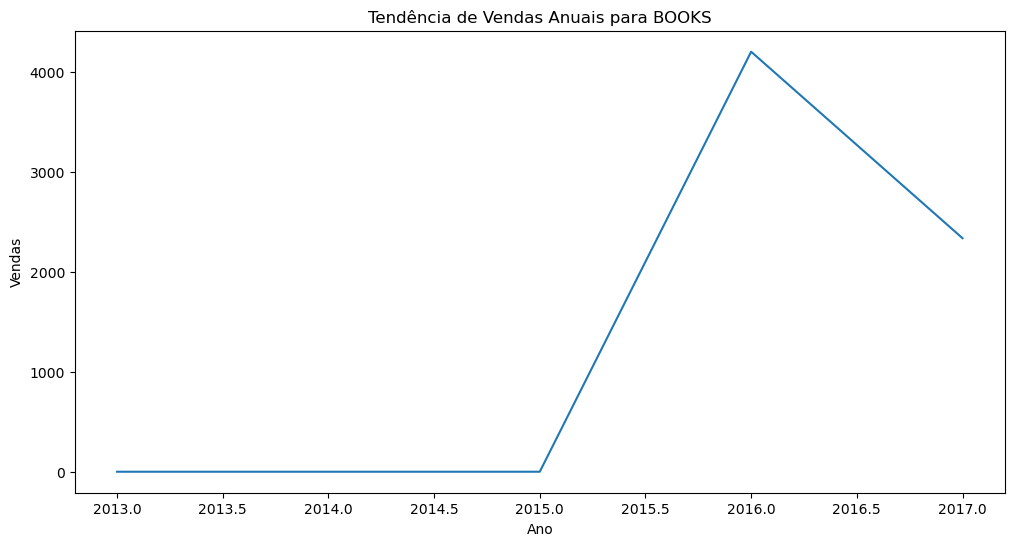

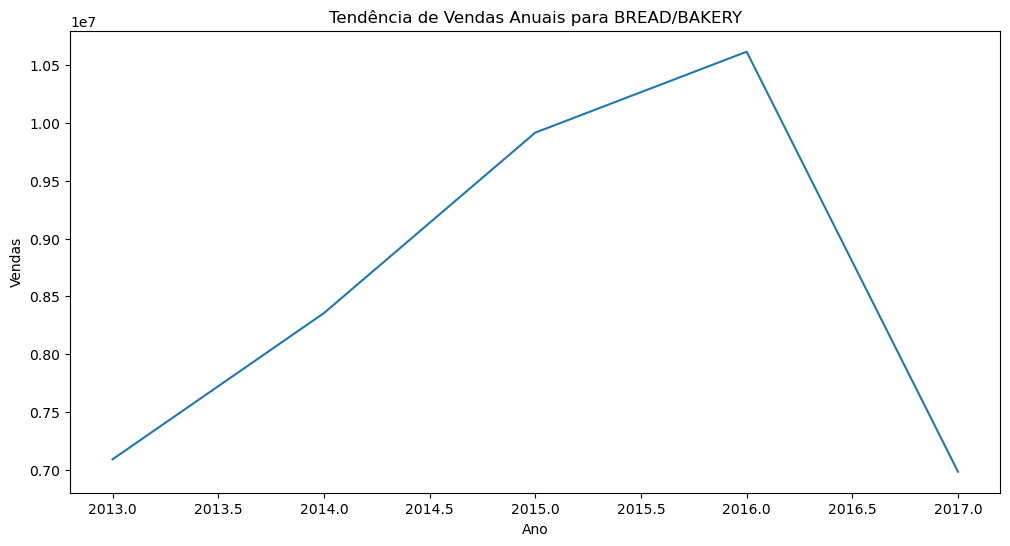

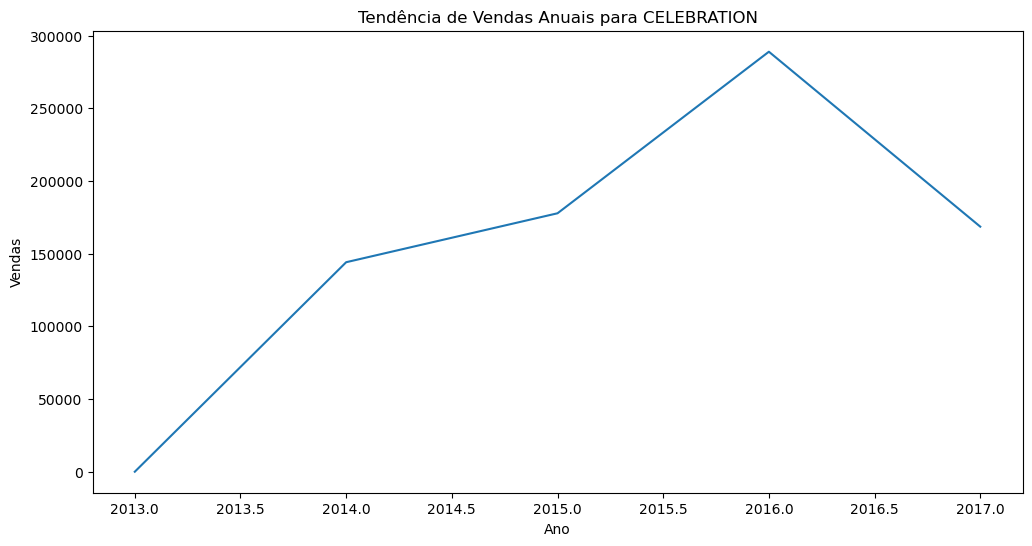

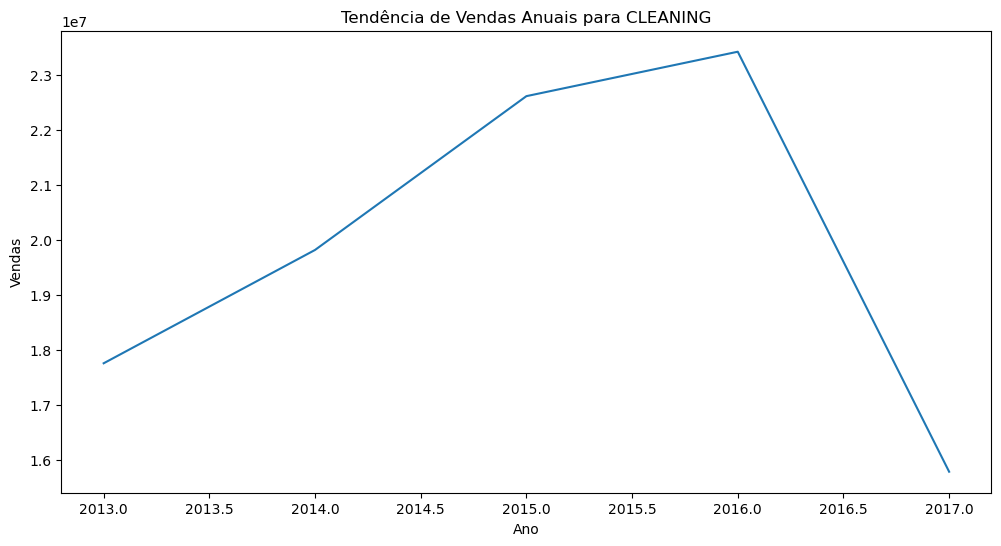

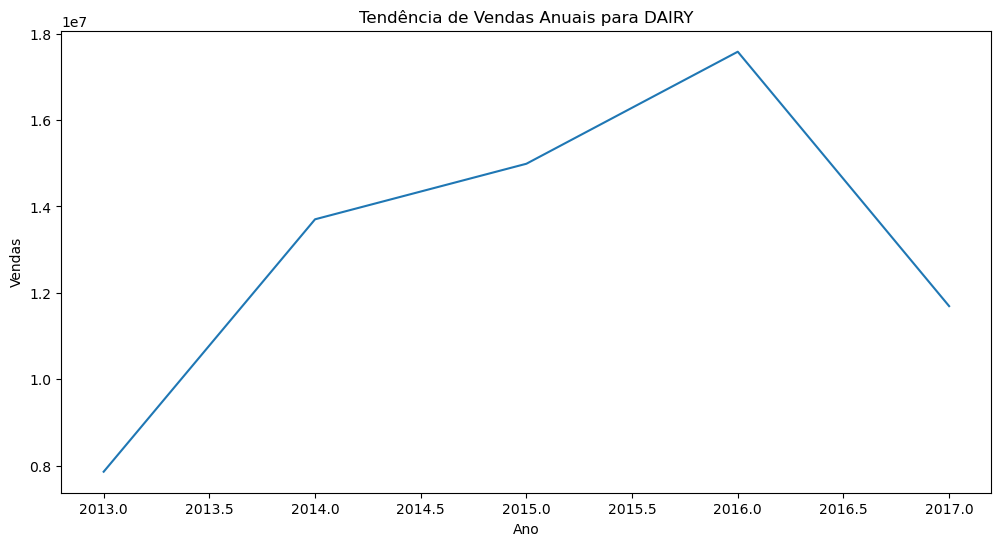

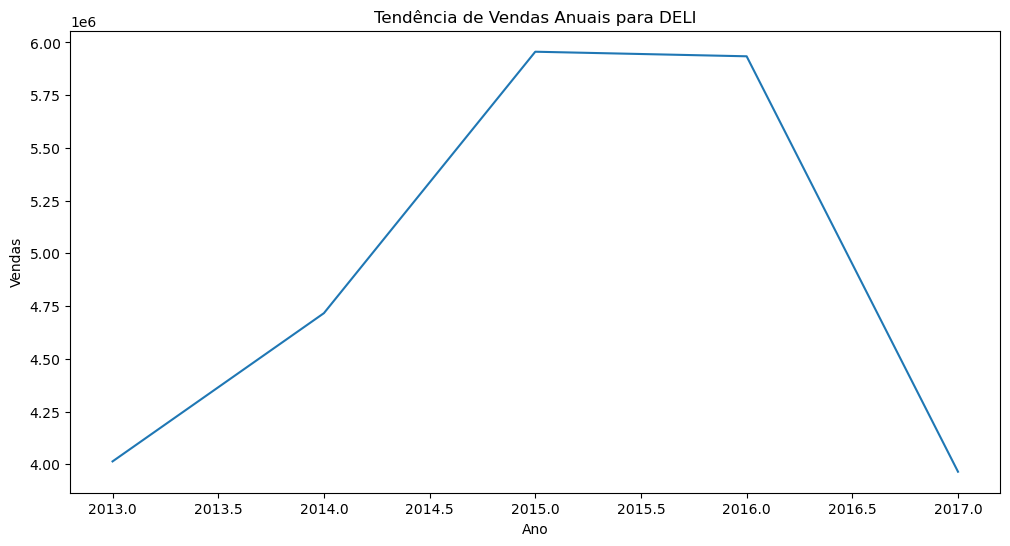

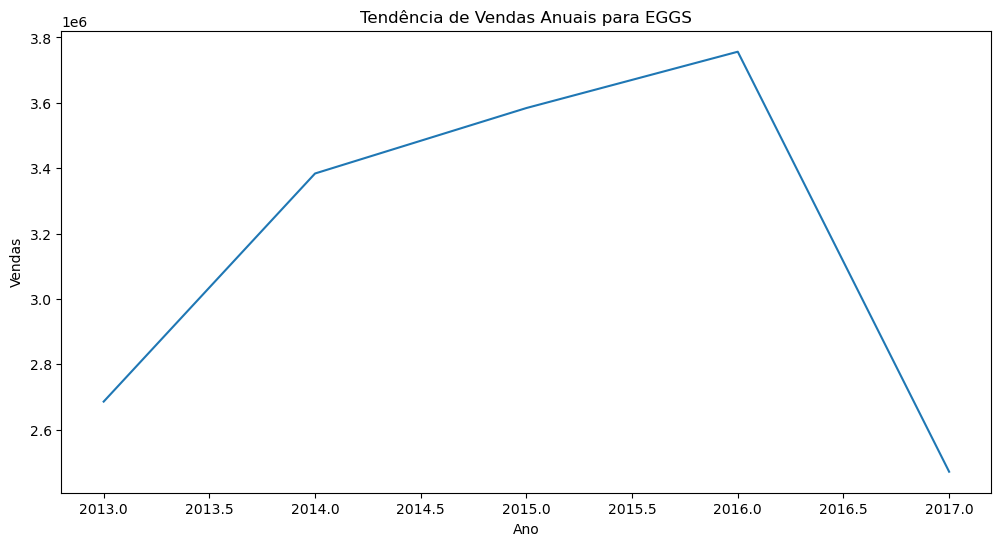

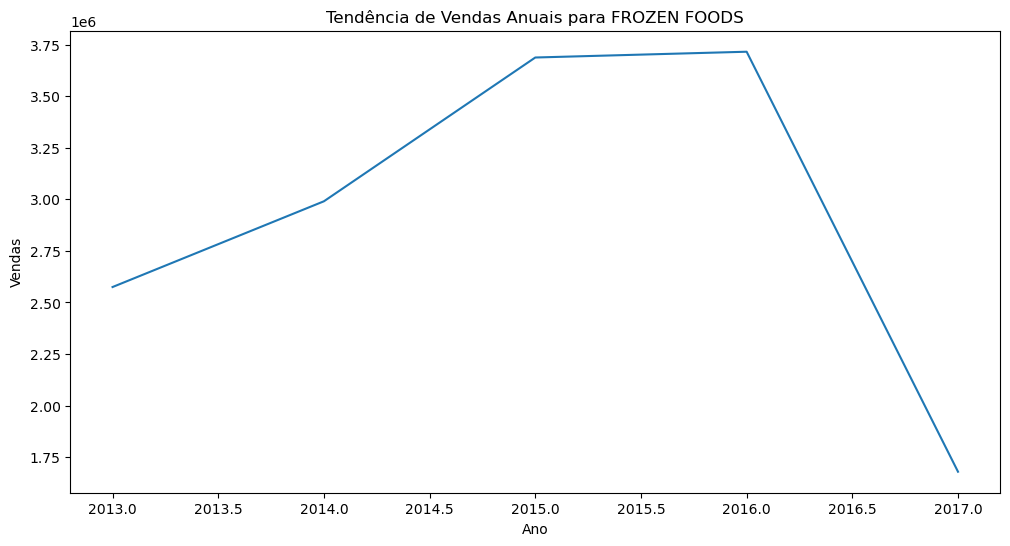

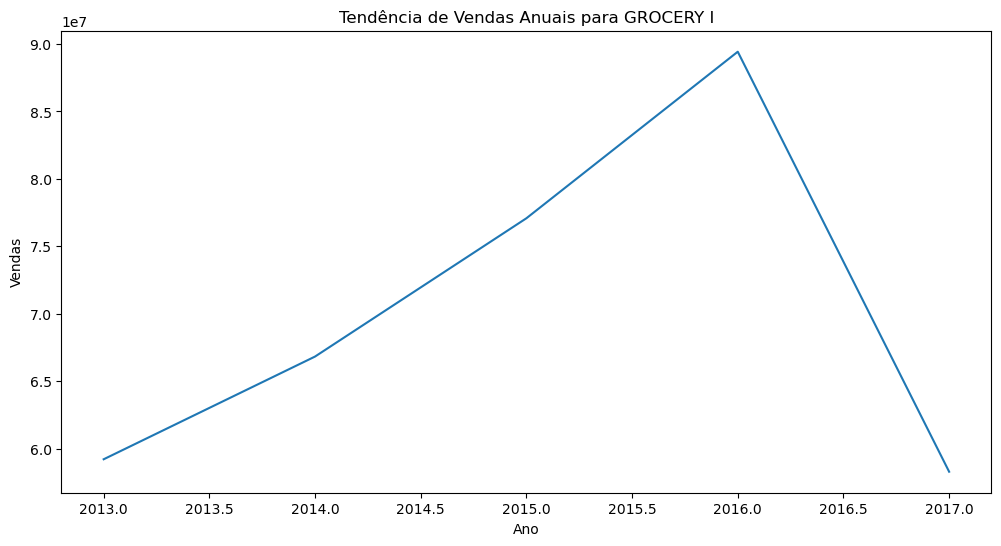

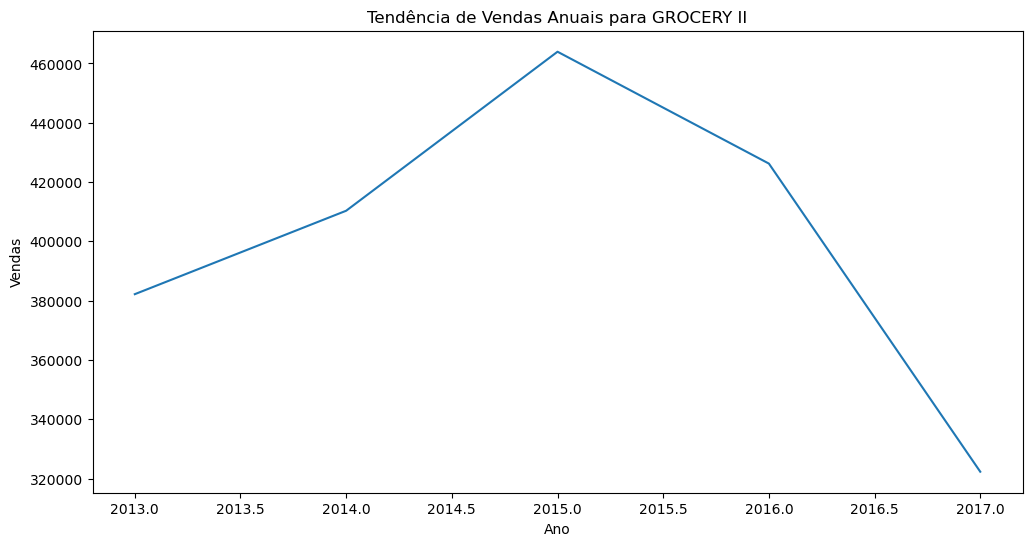

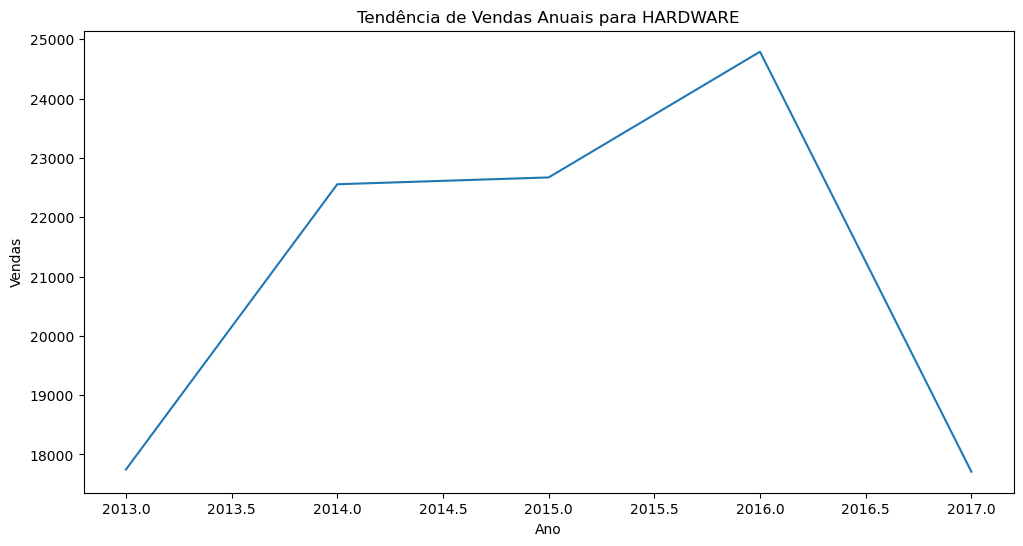

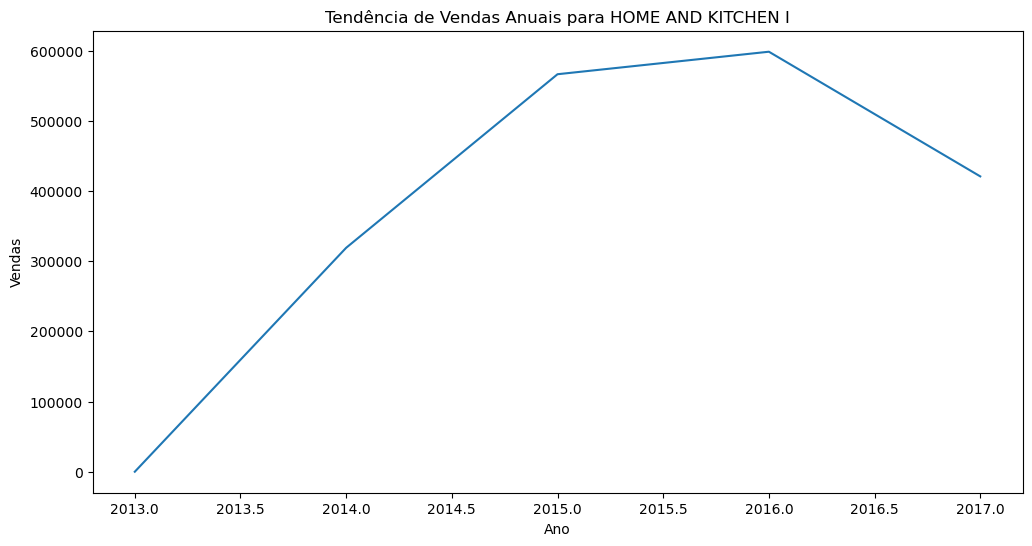

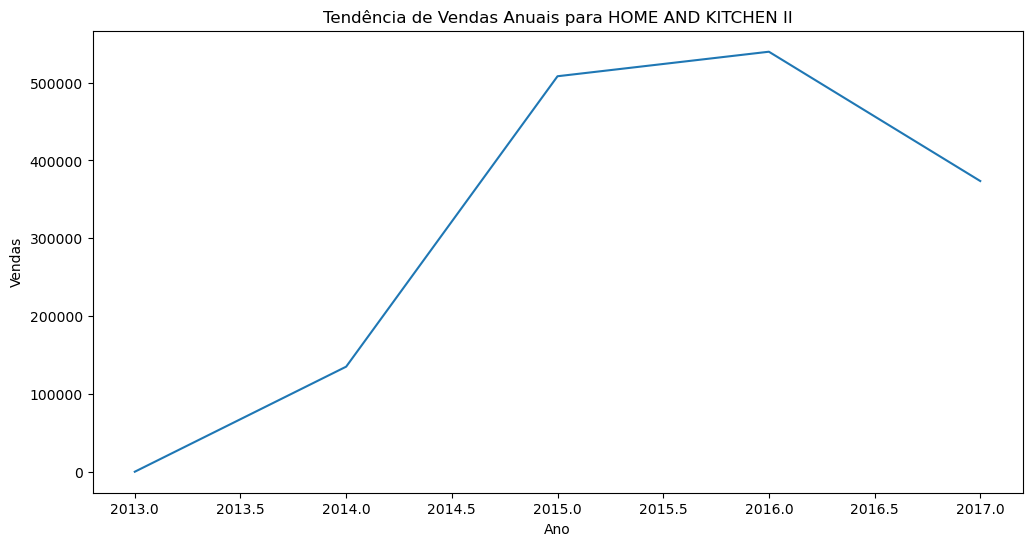

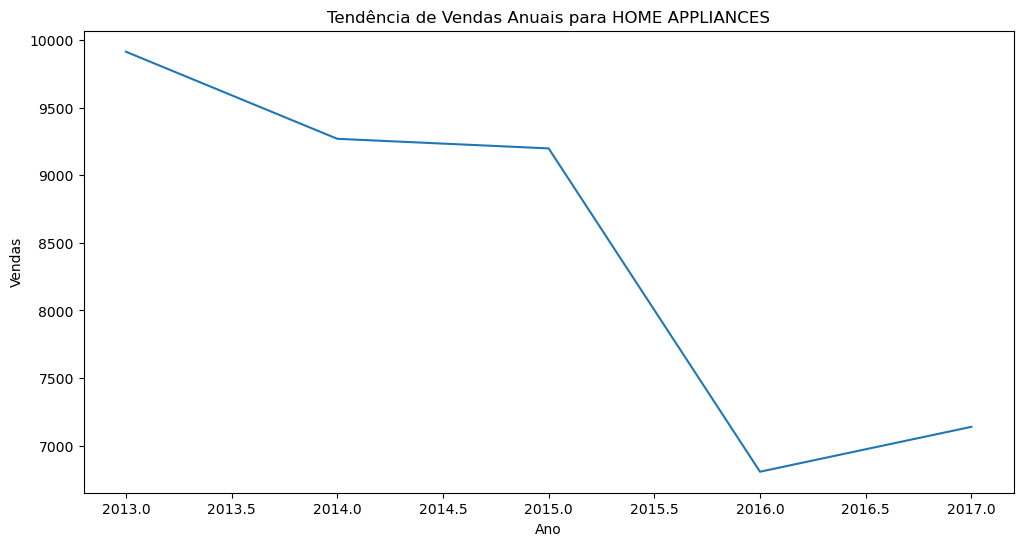

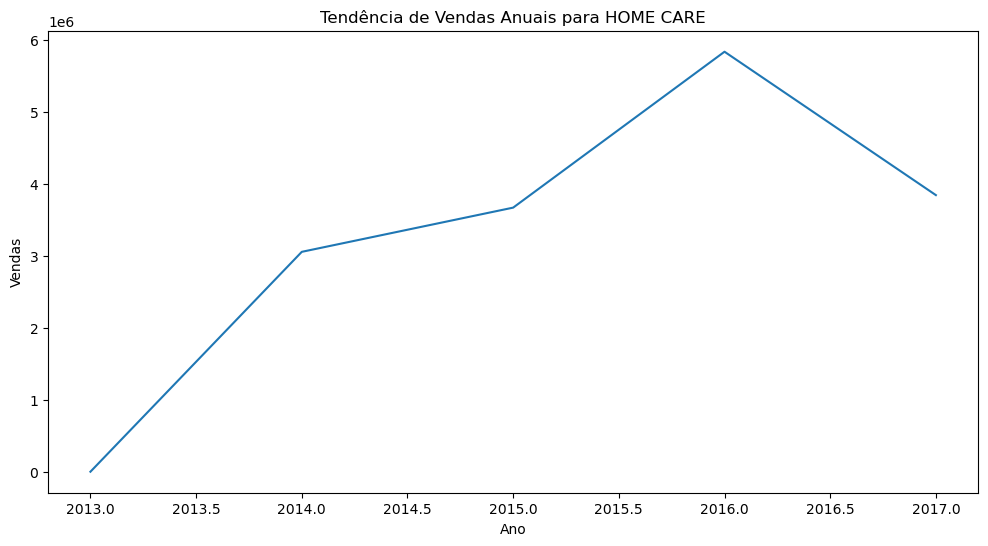

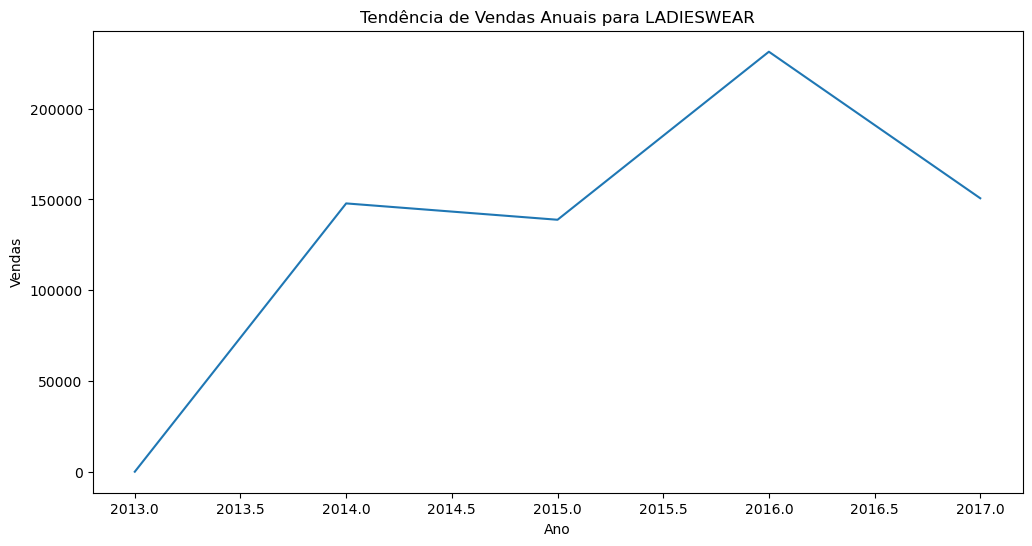

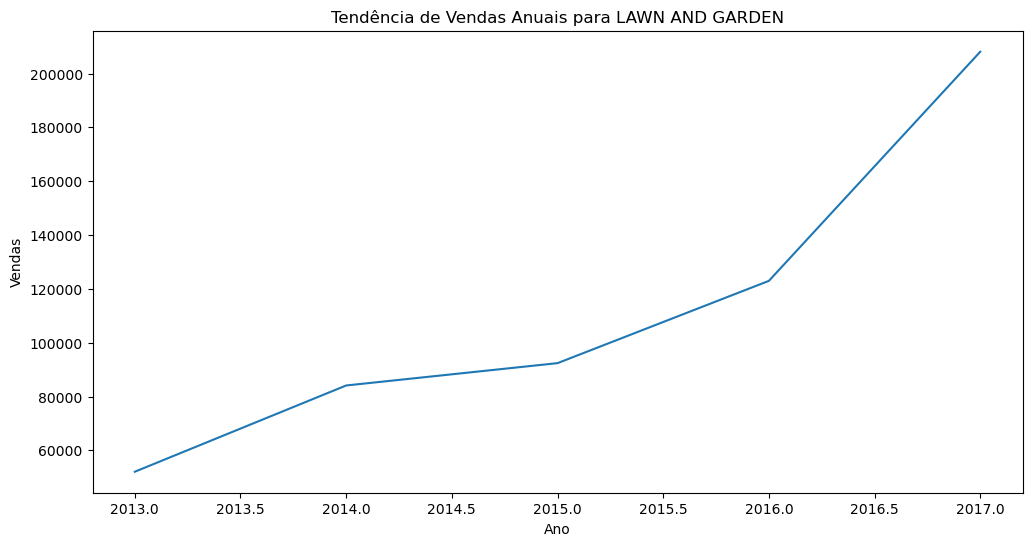

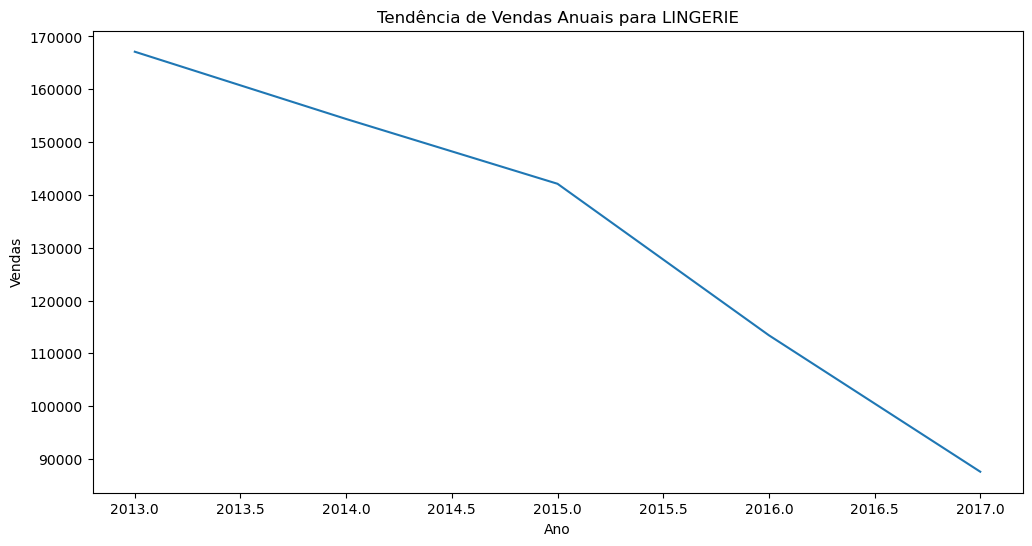

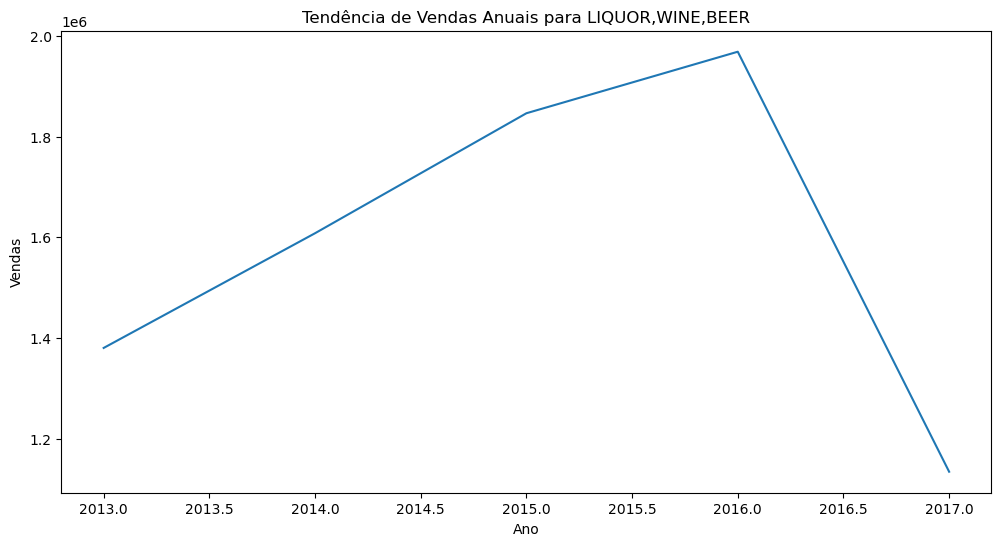

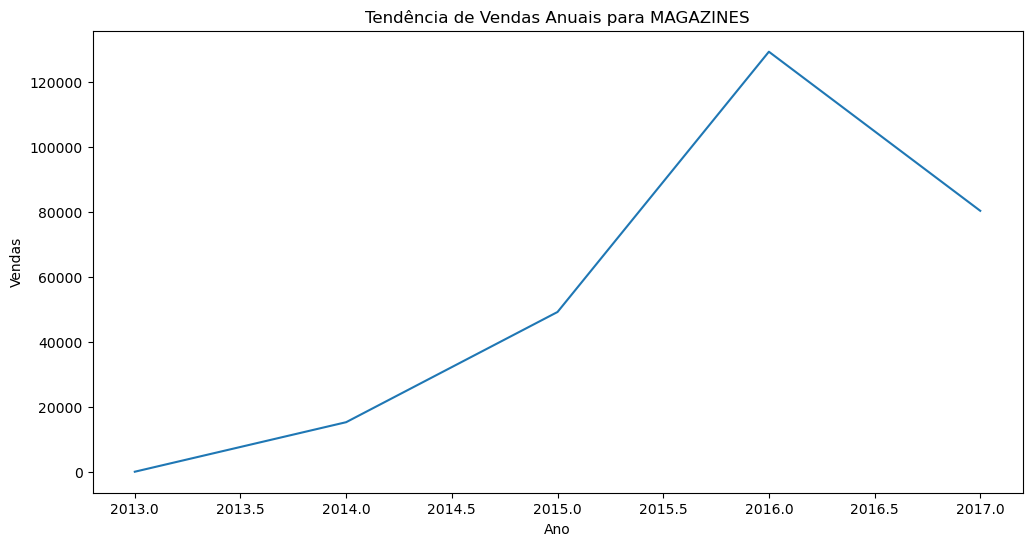

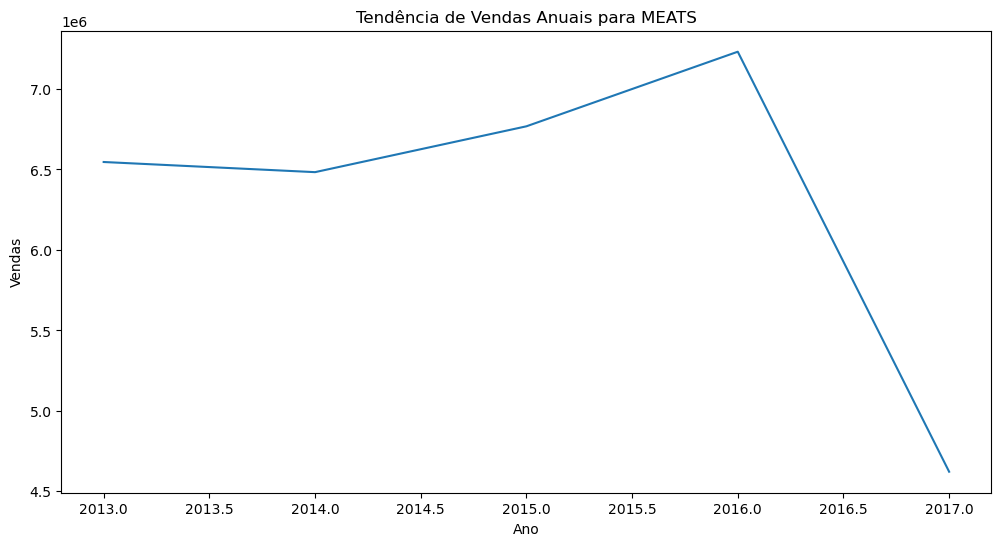

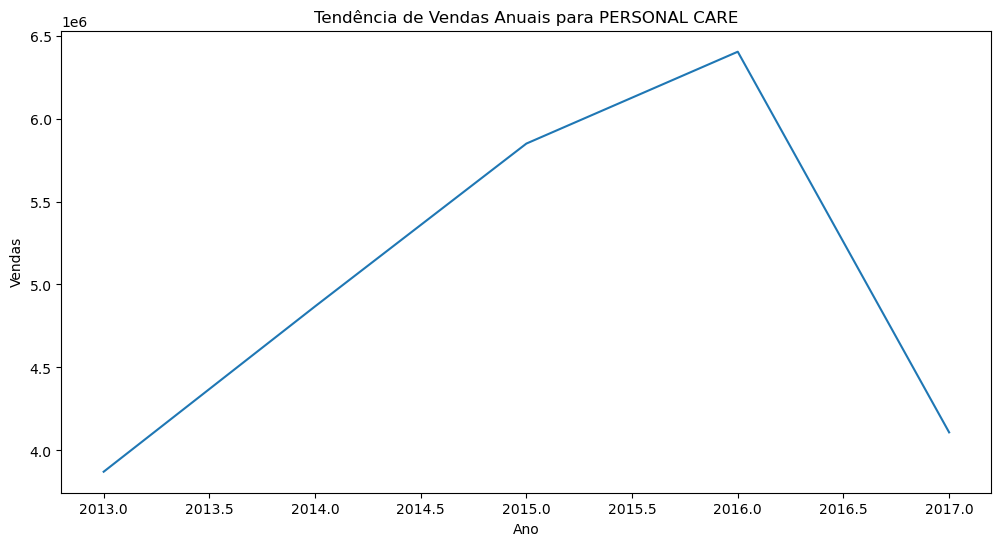

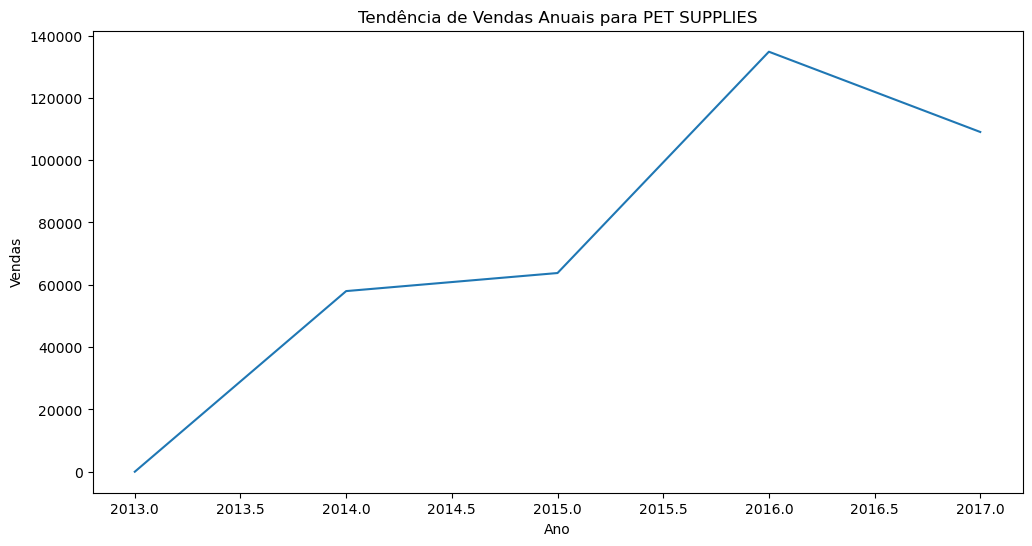

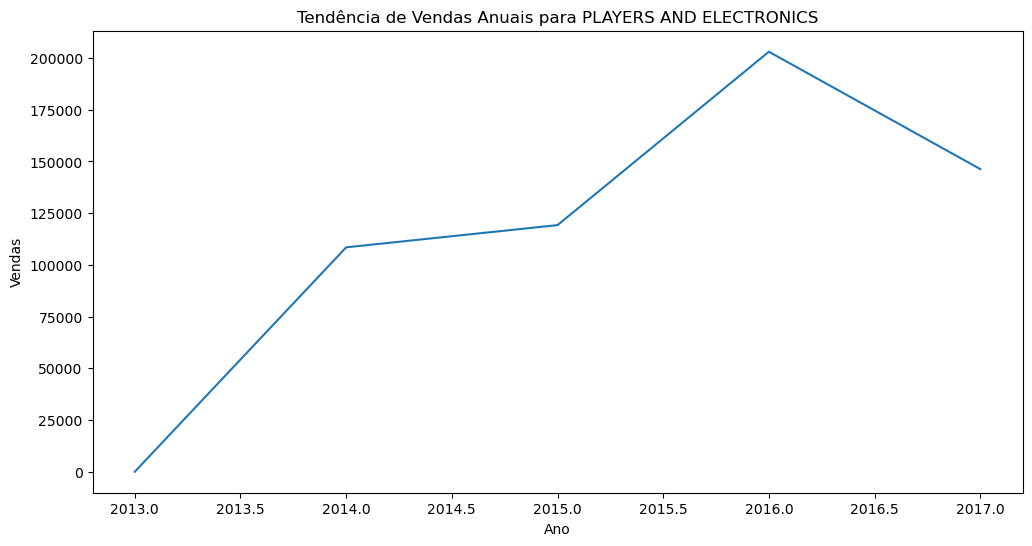

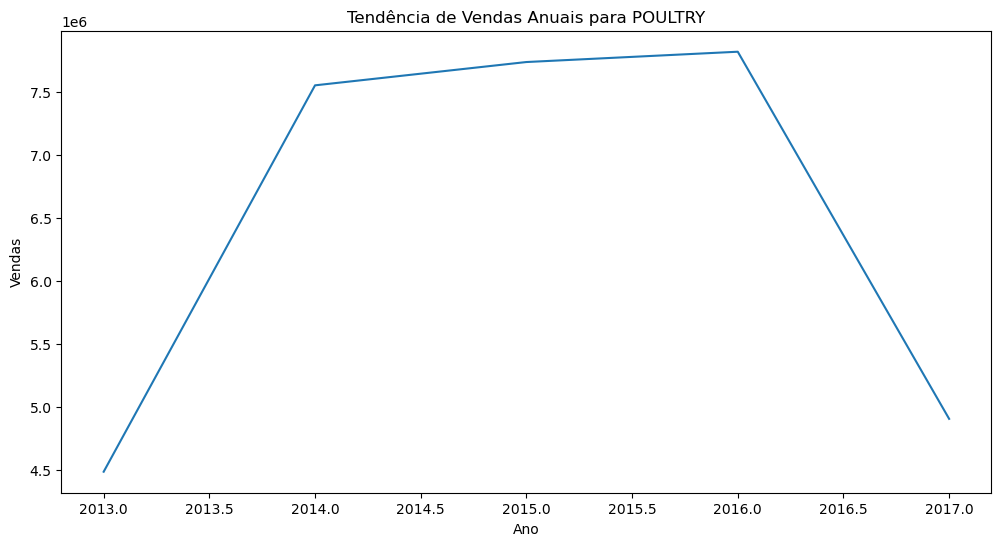

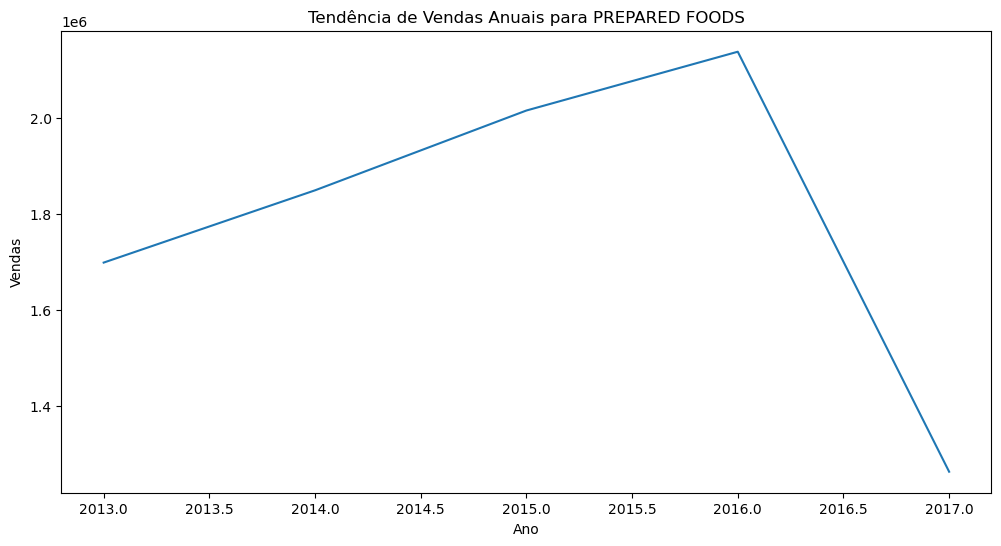

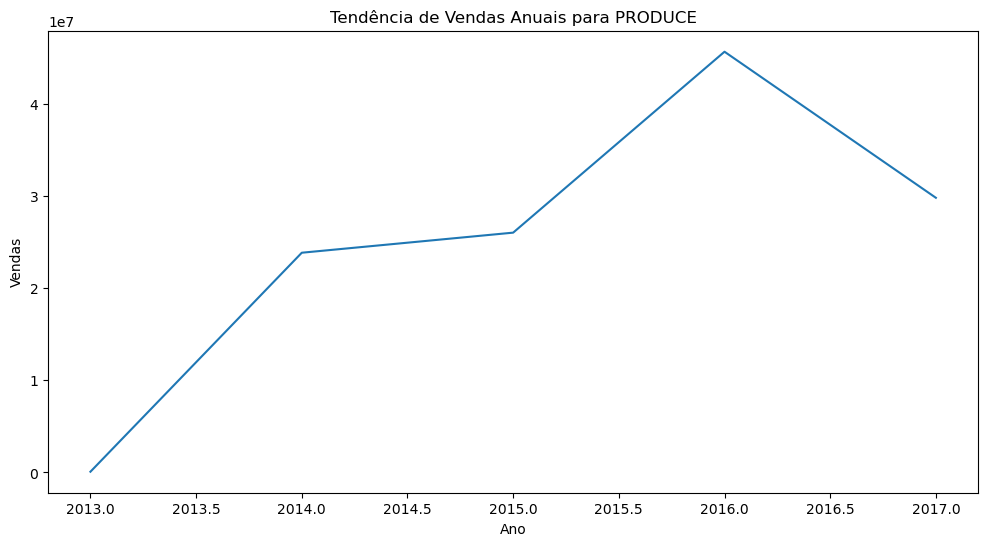

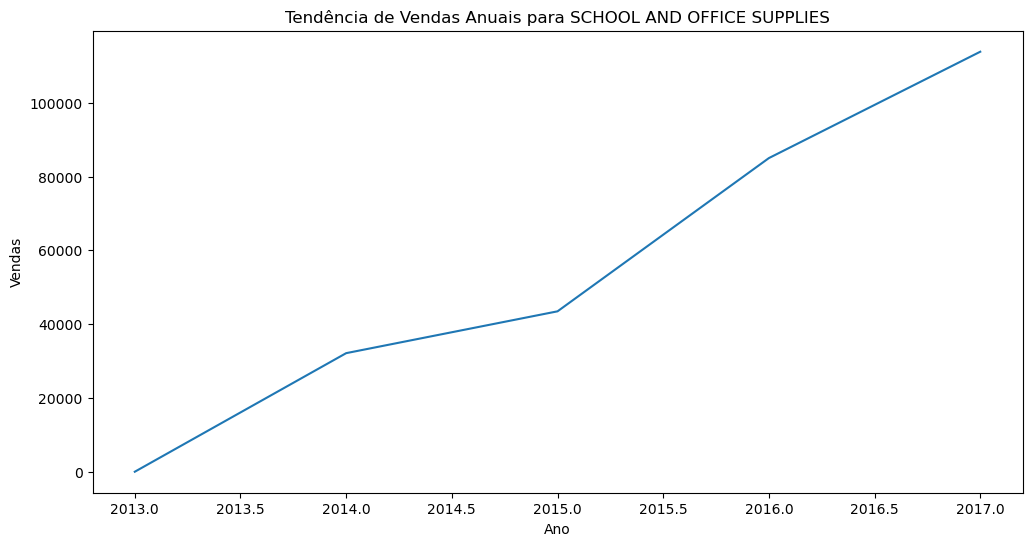

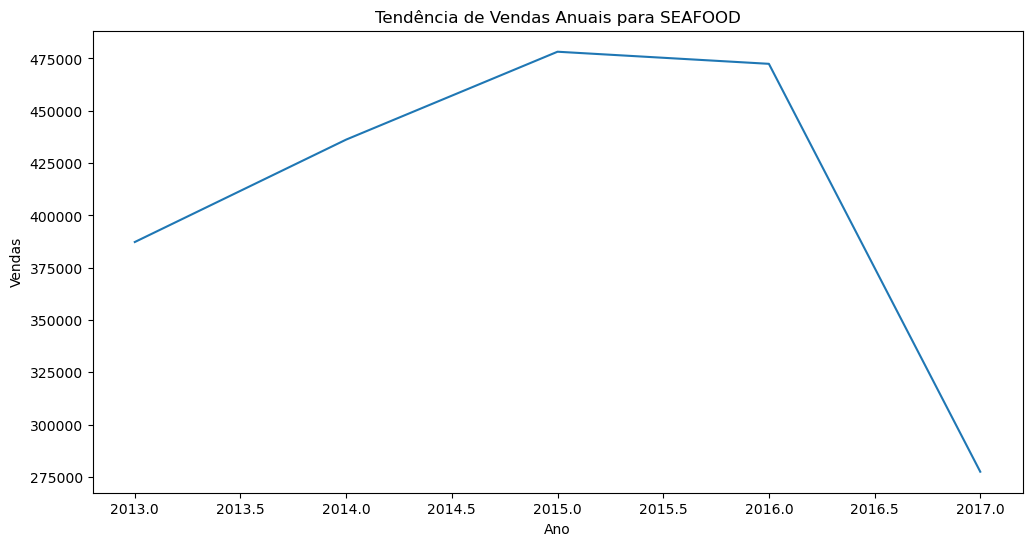

In [24]:
categorias = dados['family'].unique()
dados.set_index('date', inplace=True)
for categoria in categorias:
    plt.figure(figsize=(12, 6))
    vendas_categoria = dados[dados['family'] == categoria]['sales']
    vendas_categoria.groupby(vendas_categoria.index.year).sum().plot()
    plt.title(f'Tendência de Vendas Anuais para {categoria}')
    plt.xlabel('Ano')
    plt.ylabel('Vendas')
    plt.show()


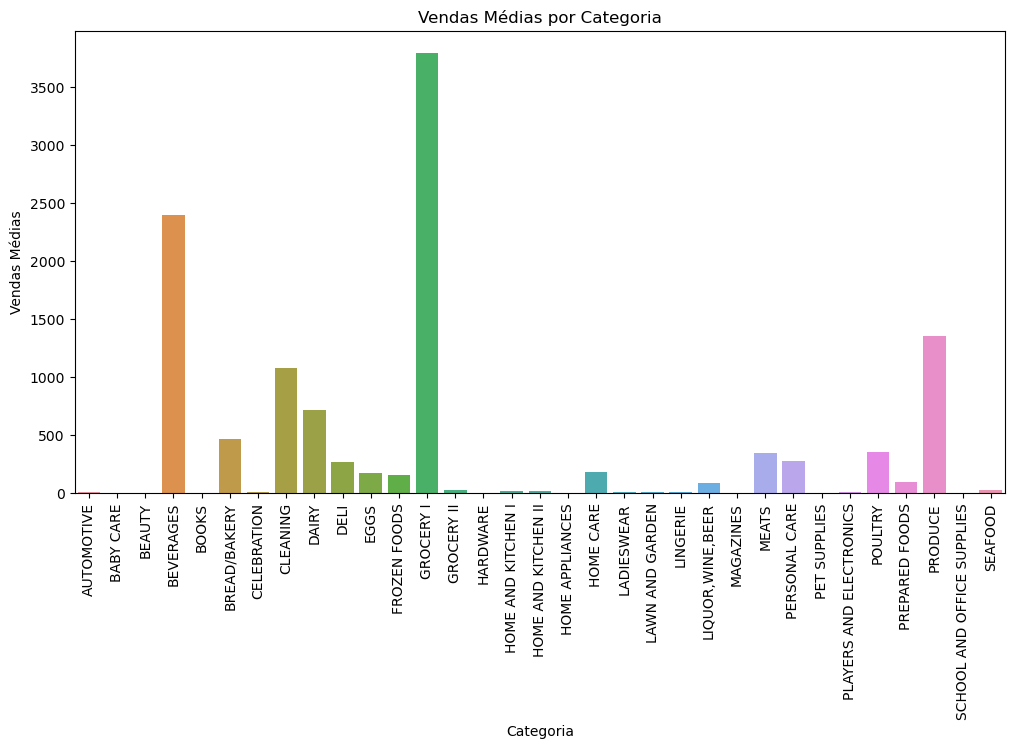

In [25]:
category_means = dados.groupby('family')['sales'].mean().reset_index()

# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='family', y='sales', data=category_means)
plt.xticks(rotation=90)
plt.title('Vendas Médias por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Vendas Médias')
plt.show()

In [31]:
dados.reset_index(inplace=True)

In [35]:
dados = dados.merge(stores[['store_nbr', 'cluster', 'type']], on='store_nbr', how='left')

In [36]:
null_counts = dados.isnull().sum()
print(null_counts)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
holiday        0
category       0
cluster        0
type           0
dtype: int64


In [27]:
dados['category'] = dados['family'].apply(map_to_macrocategory)

In [37]:
dados.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dcoilwtico            float64
holiday                 int64
category               object
cluster                 int64
type                   object
dtype: object

In [38]:
dados['dia_da_semana'] = dados['date'].dt.dayofweek  
dados['dia_do_mes'] = dados['date'].dt.day      
dados['dia_do_ano'] = dados['date'].dt.dayofyear

In [39]:
dados.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,category,cluster,type,dia_da_semana,dia_do_mes,dia_do_ano
0,2013-01-01,1,AUTOMOTIVE,0.0,0,95.0,1,Automotivo,13,D,1,1,1
1,2013-01-01,1,BABY CARE,0.0,0,95.0,1,Cuidados Pessoais e Saúde,13,D,1,1,1
2,2013-01-01,1,BEAUTY,0.0,0,95.0,1,Cuidados Pessoais e Saúde,13,D,1,1,1
3,2013-01-01,1,BEVERAGES,0.0,0,95.0,1,Alimentos e Bebidas,13,D,1,1,1
4,2013-01-01,1,BOOKS,0.0,0,95.0,1,"Lazer, Tecnologia e Ferramentas",13,D,1,1,1


In [41]:
dados["dia_de_pagamento"] = dados["date"].apply(payday)

In [42]:
dados.to_csv('dados_compactados.csv.gz', compression='gzip', index=False)

In [43]:
dados.

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday,category,cluster,type,dia_da_semana,dia_do_mes,dia_do_ano,dia_de_pagamento
0,2013-01-01,1,AUTOMOTIVE,0.0,0,95.0,1,Automotivo,13,D,1,1,1,0
1,2013-01-01,1,BABY CARE,0.0,0,95.0,1,Cuidados Pessoais e Saúde,13,D,1,1,1,0
2,2013-01-01,1,BEAUTY,0.0,0,95.0,1,Cuidados Pessoais e Saúde,13,D,1,1,1,0
3,2013-01-01,1,BEVERAGES,0.0,0,95.0,1,Alimentos e Bebidas,13,D,1,1,1,0
4,2013-01-01,1,BOOKS,0.0,0,95.0,1,"Lazer, Tecnologia e Ferramentas",13,D,1,1,1,0
